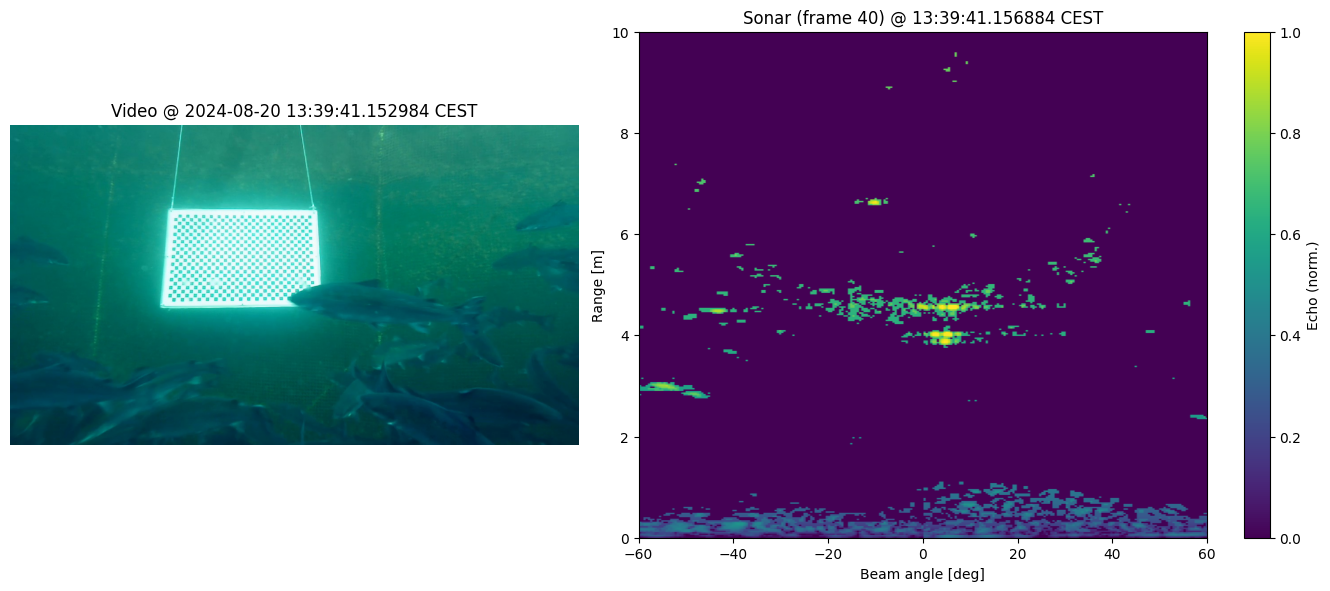

Matched video: 20240820_133941_152984+0200.png | Δt= 0 days 00:00:00.003900670


In [3]:
# === Sonar + Video side-by-side (timestamp-aligned) ===
import json, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from datetime import datetime, timezone

# ---------- CONFIG (edit these) ----------
SONAR_FILE      = Path("exports/by_bag/sensor_sonoptix_echo_image__2024-08-20_13-39-34_video.csv")
VIDEO_SEQ_DIR   = Path("exports/frames/2024-08-20_13-39-34_video__image_compressed_image_data")  # folder containing PNGs + index.csv
FRAME_INDEX     = 40                   # sonar frame to show
TIME_TOLERANCE  = pd.Timedelta("75ms")  # max allowed time difference when matching a video frame

# Sonar axes / enhancement (display only)
FOV_DEG       = 120.0
RANGE_MIN_M   = 0.0
RANGE_MAX_M   = 30.0
DISPLAY_RANGE_MAX_M = 10.0  # zoom Y to 10 m
USE_ENHANCED  = True        # True: enhanced display; False: raw
CMAP_RAW      = "viridis"
CMAP_ENH      = "viridis"

# If your sonar array looks mirrored, flip here (rows=range, cols=beams)
FLIP_BEAMS    = False
FLIP_RANGE    = False
# ----------------------------------------

# ---------- helpers ----------
def load_df(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path) if path.suffix.lower()==".parquet" else pd.read_csv(path)

def parse_json_cell(v):
    if isinstance(v, str):
        try: return json.loads(v)
        except Exception: return None
    return v

def infer_hw(labels, sizes, data_len):
    labels = [str(l or "").lower() for l in (labels or [])]
    sizes  = [int(s) for s in (sizes or [])]
    try:
        h_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("height","rows","beams")))
        w_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("width","cols","bins","range","samples")))
        H, W = sizes[h_idx], sizes[w_idx]
        if H>0 and W>0 and H*W==data_len: return H, W
    except Exception:
        pass
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            H, W = sizes[i], sizes[j]
            if H>0 and W>0 and H*W==data_len:
                return H, W
    return None, None

def get_sonoptix_frame(df, idx):
    if "image" in df.columns:
        img = parse_json_cell(df.loc[idx, "image"])
        if isinstance(img, list) and img and isinstance(img[0], list):
            return np.asarray(img, dtype=float)
    if "data" in df.columns:
        data   = parse_json_cell(df.loc[idx, "data"])
        labels = parse_json_cell(df.loc[idx, "dim_labels"]) if "dim_labels" in df.columns else None
        sizes  = parse_json_cell(df.loc[idx, "dim_sizes"])  if "dim_sizes"  in df.columns else None
        if isinstance(data, list):
            if isinstance(sizes, list):
                H, W = infer_hw(labels, sizes, len(data))
                if H and W: return np.asarray(data, dtype=float).reshape(H, W)
            H = int(df.loc[idx, "rows"]) if "rows" in df.columns and pd.notna(df.loc[idx, "rows"]) else None
            W = int(df.loc[idx, "cols"]) if "cols" in df.columns and pd.notna(df.loc[idx, "cols"]) else None
            if H and W and H*W==len(data):
                return np.asarray(data, dtype=float).reshape(H, W)
    return None

def enhance_intensity(
    M, range_min, range_max, *,
    scale="db", tvg="amplitude", alpha_db_per_m=0.0,
    r0=1e-2, p_low=1.0, p_high=99.5, gamma=0.9, zero_aware=True, eps_log=1e-6
):
    M = np.asarray(M, dtype=float)
    X = 20.0*np.log10(np.maximum(M, eps_log)) if scale=="db" else M.copy()
    n_rows = M.shape[0]
    r_edges = np.linspace(range_min, range_max, n_rows+1)
    r_cent  = 0.5*(r_edges[:-1] + r_edges[1:])
    R = np.broadcast_to(r_cent[:, None], M.shape)
    if tvg == "amplitude":
        X = X + 20.0*np.log10(np.maximum(R, r0))
    elif tvg == "power":
        X = X + 40.0*np.log10(np.maximum(R, r0))
    if alpha_db_per_m > 0:
        X = X + 2.0*alpha_db_per_m*R
    mask = np.isfinite(X); 
    if zero_aware: mask &= (M>0)
    vals = X[mask]
    if vals.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = np.percentile(vals, p_low); vmax = np.percentile(vals, p_high)
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax) or vmax<=vmin: vmax = vmin + 1e-6
    Y = np.clip((X - vmin)/(vmax - vmin), 0, 1)
    if gamma != 1.0: Y = np.power(Y, 1.0/gamma)
    return Y

def read_video_index(seq_dir: Path) -> pd.DataFrame:
    """Return DataFrame with columns ['file','ts_utc'] at least."""
    idx_path = seq_dir / "index.csv"
    if idx_path.exists():
        dfv = pd.read_csv(idx_path)
        if "ts_utc" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["ts_utc"], utc=True)
        elif "t_use" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["t_use"], unit="s", utc=True)
        else:
            raise RuntimeError("index.csv missing ts_utc/t_use columns.")
        if "file" not in dfv.columns:
            # fall back to listing files if needed
            dfv["file"] = [p.name for p in seq_dir.glob("*.png")]
        return dfv[["file","ts_utc"]].sort_values("ts_utc").reset_index(drop=True)

    # Fallback: parse timestamps from filenames like YYYYmmdd_HHMMSS_micro+ZZZZ.png
    rows = []
    rx = re.compile(r"(\d{8})_(\d{6})_(\d{6})([+\-]\d{4})")
    for p in sorted(seq_dir.glob("*.png")):
        m = rx.search(p.stem)
        if not m: 
            continue
        ymd, hms, micro, tz = m.groups()
        # Build a UTC datetime by parsing local and subtracting tz offset
        dt = datetime.strptime(ymd+hms+micro+tz, "%Y%m%d%H%M%S%f%z")
        rows.append({"file": p.name, "ts_utc": dt.astimezone(timezone.utc)})
    if not rows:
        raise FileNotFoundError("No index.csv and could not parse timestamps from filenames.")
    return pd.DataFrame(rows).sort_values("ts_utc").reset_index(drop=True)

def load_png_rgb(path: Path) -> np.ndarray:
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None: 
        raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# ---------- load sonar ----------
dfs = load_df(SONAR_FILE)
if "ts_utc" not in dfs.columns:
    if "t" not in dfs.columns:
        raise RuntimeError("Sonar file missing 't' column for timestamps.")
    dfs["ts_utc"] = pd.to_datetime(dfs["t"], unit="s", utc=True)

# pick sonar frame & build image (rows=range, cols=beams)
M0 = get_sonoptix_frame(dfs, FRAME_INDEX)
if M0 is None:
    raise RuntimeError("Could not construct a Sonoptix frame from this file.")
M = M0.copy()
if FLIP_RANGE: M = M[::-1, :]
if FLIP_BEAMS: M = M[:, ::-1]
H, W = M.shape

# sonar display data
theta_min_deg = -0.5 * FOV_DEG
theta_max_deg =  0.5 * FOV_DEG
extent_xy = (theta_min_deg, theta_max_deg, RANGE_MIN_M, RANGE_MAX_M)

M_raw = M
vmin_raw, vmax_raw = float(np.nanmin(M_raw)), float(np.nanmax(M_raw))
M_enh = enhance_intensity(M, RANGE_MIN_M, RANGE_MAX_M) if USE_ENHANCED else M_raw

# ---------- load video index & find nearest ----------
dfv = read_video_index(VIDEO_SEQ_DIR)
ts_target = dfs.loc[FRAME_INDEX, "ts_utc"]

# ---------- robust nearest-match by timestamp (pandas-native) ----------
# normalize video timestamps to tz-aware UTC
dfv["ts_utc"] = pd.to_datetime(dfv["ts_utc"], utc=True, errors="coerce")
dfv = dfv.dropna(subset=["ts_utc"]).sort_values("ts_utc").reset_index(drop=True)
if dfv.empty:
    raise RuntimeError("Video index has no valid timestamps.")

# normalize the sonar target timestamp too
ts_target = pd.to_datetime(dfs.loc[FRAME_INDEX, "ts_utc"], utc=True)

# find nearest index using pandas (handles tz-aware datetimes)
idx_near = pd.Index(dfv["ts_utc"]).get_indexer([ts_target], method="nearest")[0]
if idx_near < 0:
    raise RuntimeError("Could not find a nearest video frame (indexer returned -1).")

# compute time delta to the match and enforce tolerance
dt_best = (dfv.loc[idx_near, "ts_utc"] - ts_target)
dt_best = abs(dt_best)  # Timedelta

if dt_best > TIME_TOLERANCE:
    print(f"(warn) No video frame within {TIME_TOLERANCE} of sonar ts={ts_target}. "
          f"Nearest Δt={dt_best} at file={dfv.loc[idx_near,'file']}")

# use this frame
j_best = idx_near
video_file = VIDEO_SEQ_DIR / dfv.loc[j_best, "file"]
img_rgb = load_png_rgb(video_file)

# ---------- plot side-by-side ----------
fig, axes = plt.subplots(1, 2, figsize=(13.2, 5.8), constrained_layout=True)

# Video
axes[0].imshow(img_rgb)
axes[0].set_title(f"Video @ {dfv.loc[j_best, 'ts_utc'].tz_convert('Europe/Oslo'):%Y-%m-%d %H:%M:%S.%f %Z}")
axes[0].axis("off")

# Sonar
im = axes[1].imshow(M_enh, origin="lower", aspect="auto", extent=extent_xy,
                    vmin=(0 if USE_ENHANCED else vmin_raw),
                    vmax=(1 if USE_ENHANCED else vmax_raw),
                    cmap=(CMAP_ENH if USE_ENHANCED else CMAP_RAW))
axes[1].set_title(f"Sonar (frame {FRAME_INDEX}) @ {ts_target.tz_convert('Europe/Oslo'):%H:%M:%S.%f %Z}")
axes[1].set_xlabel("Beam angle [deg]"); axes[1].set_ylabel("Range [m]")
axes[1].set_ylim(RANGE_MIN_M, DISPLAY_RANGE_MAX_M)
cb = fig.colorbar(im, ax=axes[1], label=("Echo (norm.)" if USE_ENHANCED else "Echo (raw)"))

plt.show()

print("Matched video:", video_file.name, "| Δt=", dt_best)


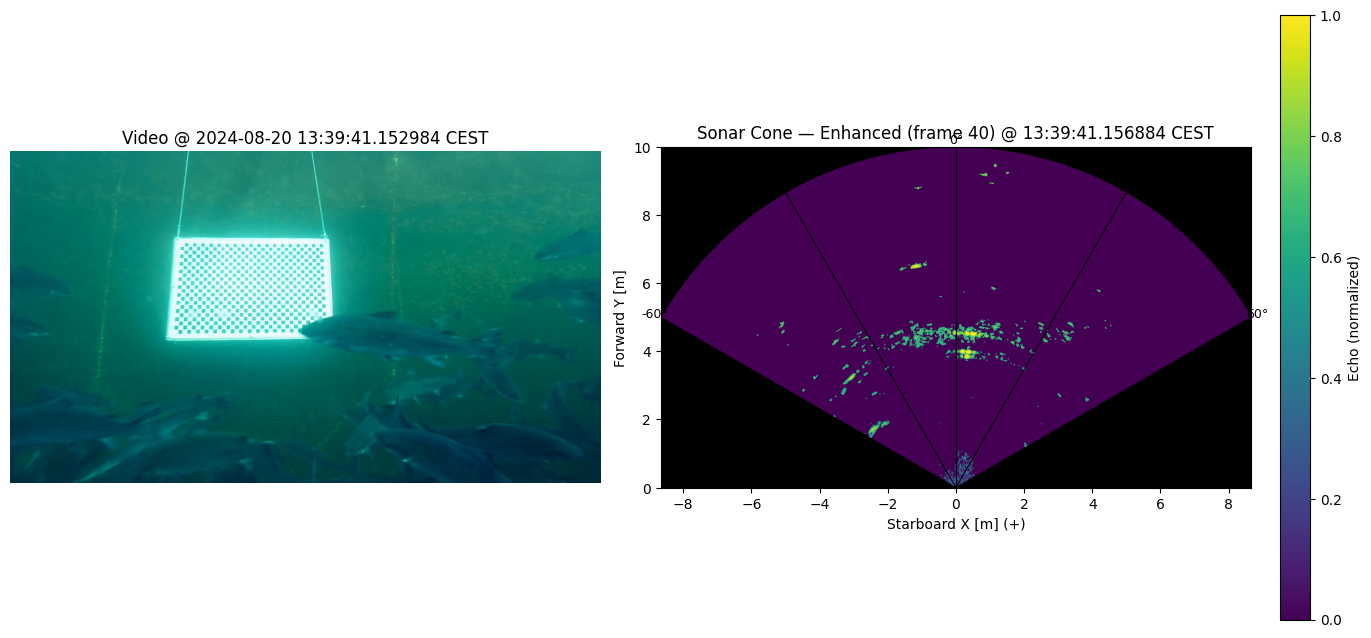

In [5]:
# === Video + Sonar Cone (timestamp-aligned) ===
import numpy as np
import matplotlib.pyplot as plt

# ---- guards: ensure previous cell ran ----
needed = ["FOV_DEG","RANGE_MIN_M","RANGE_MAX_M","H","W"]
for n in needed:
    if n not in globals():
        raise RuntimeError(f"Missing '{n}'. Run the sonar+video alignment cell first.")

USE_ENHANCED = globals().get("USE_ENHANCED", True)
DISPLAY_RANGE_MAX_M = globals().get("DISPLAY_RANGE_MAX_M", RANGE_MAX_M)
CMAP_RAW  = globals().get("CMAP_RAW",  "viridis")
CMAP_ENH  = globals().get("CMAP_ENH",  "viridis")
FRAME_INDEX = globals().get("FRAME_INDEX", None)

# ---- choose sonar data & scale ----
if USE_ENHANCED:
    if "M_enh" not in globals():
        raise RuntimeError("Missing 'M_enh'. Run the sonar+video cell first.")
    Z = M_enh
    vmin, vmax = 0.0, 1.0
    cmap_name = CMAP_ENH
    mode_name = "Enhanced"
else:
    if "M_raw" not in globals():
        raise RuntimeError("Missing 'M_raw'. Run the sonar+video cell first.")
    Z = M_raw
    vmin = float(np.nanmin(Z))
    vmax = float(np.nanmax(Z))
    cmap_name = CMAP_RAW
    mode_name = "Raw"

H, W = int(H), int(W)

# ---- cone geometry & rasterization ----
half = np.deg2rad(0.5 * FOV_DEG)
y_min = max(0.0, float(RANGE_MIN_M))
y_max = float(DISPLAY_RANGE_MAX_M)  # crop fan to display range
x_max =  np.sin(half) * y_max
x_min = -x_max

# raster resolution
IMG_W, IMG_H = 900, 700
x = np.linspace(x_min, x_max, IMG_W)
y = np.linspace(y_min, y_max, IMG_H)
Xg, Yg = np.meshgrid(x, y)

# polar from +Y axis (forward), starboard positive
theta = np.arctan2(Xg, Yg)
r     = np.hypot(Xg, Yg)

# sector mask
mask = (r >= RANGE_MIN_M) & (r <= y_max) & (theta >= -half) & (theta <= +half)

# map (r,theta) -> (row, col) in Z (rows=range, cols=beams)
rowf = (r - RANGE_MIN_M) / max((RANGE_MAX_M - RANGE_MIN_M), 1e-12) * (H - 1)
colf = (theta + half)       / max((2*half),                    1e-12) * (W - 1)
rows = np.rint(np.clip(rowf, 0, H - 1)).astype(np.int32)
cols = np.rint(np.clip(colf, 0, W - 1)).astype(np.int32)

# build cone raster with NaN background
cone = np.full((IMG_H, IMG_W), np.nan, dtype=float)
mflat = mask.ravel()
cone.ravel()[mflat] = Z[rows.ravel()[mflat], cols.ravel()[mflat]]

cmap = plt.get_cmap(cmap_name).copy()
cmap.set_bad("black")

# ---- get the matched video frame (use img_rgb if present, else load from dfv/j_best) ----
if "img_rgb" not in globals():
    if "dfv" in globals() and "j_best" in globals() and "VIDEO_SEQ_DIR" in globals():
        from pathlib import Path
        import cv2
        video_file = Path(VIDEO_SEQ_DIR) / dfv.loc[j_best, "file"]
        bgr = cv2.imread(str(video_file), cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(video_file)
        img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    else:
        raise RuntimeError("Missing 'img_rgb' and no dfv/j_best/VIDEO_SEQ_DIR to load it. Run the previous cell first.")

# ---- timestamps for titles (best-effort) ----
if "ts_target" in globals():
    try:
        ts_sonar_oslo = ts_target.tz_convert("Europe/Oslo")
    except Exception:
        ts_sonar_oslo = ts_target
else:
    ts_sonar_oslo = None

if "dfv" in globals() and "j_best" in globals():
    try:
        ts_video_oslo = dfv.loc[j_best, "ts_utc"].tz_convert("Europe/Oslo")
    except Exception:
        ts_video_oslo = dfv.loc[j_best, "ts_utc"]
else:
    ts_video_oslo = None

# ---- plot: left = video, right = cone ----
fig, axes = plt.subplots(1, 2, figsize=(13.6, 6.8), constrained_layout=True)

# video
axes[0].imshow(img_rgb)
title_video = "Video"
if ts_video_oslo is not None:
    title_video += f" @ {ts_video_oslo:%Y-%m-%d %H:%M:%S.%f %Z}"
axes[0].set_title(title_video)
axes[0].axis("off")

# cone
im = axes[1].imshow(cone, origin="lower",
                    extent=(x_min, x_max, y_min, y_max),
                    aspect="equal", cmap=cmap, vmin=vmin, vmax=vmax)

# spokes (no arcs)
N_SPOKES = 5
for a in np.linspace(-np.rad2deg(half), np.rad2deg(half), N_SPOKES):
    th = np.deg2rad(a)
    axes[1].plot([0, y_max*np.sin(th)], [0, y_max*np.cos(th)], color="k", lw=0.9, alpha=0.85)
    axes[1].text(1.02*y_max*np.sin(th), 1.02*y_max*np.cos(th), f"{a:.0f}°",
                 ha="center", va="center", fontsize=9)

axes[1].set_xlabel("Starboard X [m] (+)")
axes[1].set_ylabel("Forward Y [m]")
title_cone = f"Sonar Cone — {mode_name}"
if FRAME_INDEX is not None:
    title_cone += f" (frame {FRAME_INDEX})"
if ts_sonar_oslo is not None:
    title_cone += f" @ {ts_sonar_oslo:%H:%M:%S.%f %Z}"
axes[1].set_title(title_cone)

fig.colorbar(im, ax=axes[1], pad=0.02, shrink=0.9,
             label=("Echo (normalized)" if USE_ENHANCED else "Echo (raw units)"))

plt.show()

In [4]:
# === Sonar + Camera Side-by-Side VIDEO (with optional vertical cone flip) ===
import os, re, json
from pathlib import Path
from datetime import datetime, timezone
try:
    from zoneinfo import ZoneInfo
except Exception:
    ZoneInfo = None

import numpy as np
import pandas as pd
import cv2
import matplotlib.cm as cm

# ---------- CONFIG (edit these) ----------
SONAR_FILE     = Path("exports/by_bag/sensor_sonoptix_echo_image__2024-08-22_14-06-43_video.csv")
VIDEO_SEQ_DIR  = Path("exports/frames/2024-08-22_14-06-43_video__image_compressed_image_data")
OUT_DIR        = Path("exports/videos")

# Selection / speed
START_IDX      = 0
END_IDX        = None
STRIDE         = 1
TARGET_FPS     = None

# Timestamp matching
TIME_TOLERANCE = pd.Timedelta("100ms")

# Sonar geometry / display (must match your static cone cell)
FOV_DEG              = 120.0
RANGE_MIN_M          = 0.0
RANGE_MAX_M          = 30.0
DISPLAY_RANGE_MAX_M  = 10.0
FLIP_BEAMS           = True
FLIP_RANGE           = False

# Enhancement (display only)
USE_ENHANCED         = True
ENH_SCALE            = "db"          # "db" | "linear"
ENH_TVG              = "amplitude"   # "none" | "amplitude" | "power"
ENH_ALPHA_DB_PER_M   = 0.0
ENH_R0               = 1e-2
ENH_P_LOW            = 1.0
ENH_P_HIGH           = 99.5
ENH_GAMMA            = 0.9
ENH_ZERO_AWARE       = True
ENH_EPS_LOG          = 1e-6

# Visuals / sizes
CMAP_RAW     = "viridis"
CMAP_ENH     = "viridis"
CONE_W, CONE_H = 900, 700
VIDEO_HEIGHT   = CONE_H
PAD_BETWEEN    = 8
FONT_SCALE     = 0.55

# <<< NEW: flip cone vertically (top↔bottom). True puts apex at the bottom. >>>
CONE_FLIP_VERTICAL = True
# ----------------------------------------

# ---------- helpers ----------
def load_df(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path) if path.suffix.lower()==".parquet" else pd.read_csv(path)

def parse_json_cell(v):
    if isinstance(v, str):
        try: return json.loads(v)
        except Exception: return None
    return v

def infer_hw(labels, sizes, data_len):
    labels = [str(l or "").lower() for l in (labels or [])]
    sizes  = [int(s) for s in (sizes or [])]
    try:
        h_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("height","rows","beams")))
        w_idx = max(i for i,l in enumerate(labels) if any(k in l for k in ("width","cols","bins","range","samples")))
        H, W = sizes[h_idx], sizes[w_idx]
        if H>0 and W>0 and H*W==data_len: return H, W
    except Exception:
        pass
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            H, W = sizes[i], sizes[j]
            if H>0 and W>0 and H*W==data_len:
                return H, W
    return None, None

def get_sonoptix_frame(df: pd.DataFrame, idx: int):
    if "image" in df.columns:
        img = parse_json_cell(df.loc[idx, "image"])
        if isinstance(img, list) and img and isinstance(img[0], list):
            return np.asarray(img, dtype=float)
    if "data" in df.columns:
        data   = parse_json_cell(df.loc[idx, "data"])
        labels = parse_json_cell(df.loc[idx, "dim_labels"]) if "dim_labels" in df.columns else None
        sizes  = parse_json_cell(df.loc[idx, "dim_sizes"])  if "dim_sizes"  in df.columns else None
        if isinstance(data, list):
            if isinstance(sizes, list):
                H, W = infer_hw(labels, sizes, len(data))
                if H and W: return np.asarray(data, dtype=float).reshape(H, W)
            H = int(df.loc[idx, "rows"]) if "rows" in df.columns and pd.notna(df.loc[idx, "rows"]) else None
            W = int(df.loc[idx, "cols"]) if "cols" in df.columns and pd.notna(df.loc[idx, "cols"]) else None
            if H and W and H*W==len(data):
                return np.asarray(data, dtype=float).reshape(H, W)
    return None

def enhance_intensity(M, range_min, range_max, *,
                      scale=ENH_SCALE, tvg=ENH_TVG, alpha_db_per_m=ENH_ALPHA_DB_PER_M,
                      r0=ENH_R0, p_low=ENH_P_LOW, p_high=ENH_P_HIGH,
                      gamma=ENH_GAMMA, zero_aware=ENH_ZERO_AWARE, eps_log=ENH_EPS_LOG):
    M = np.asarray(M, dtype=float)
    X = 20.0*np.log10(np.maximum(M, eps_log)) if scale=="db" else M.copy()
    n_rows = M.shape[0]
    r_edges = np.linspace(range_min, range_max, n_rows+1)
    r_cent  = 0.5*(r_edges[:-1] + r_edges[1:])
    R = np.broadcast_to(r_cent[:, None], M.shape)
    if tvg == "amplitude":
        X = X + 20.0*np.log10(np.maximum(R, r0))
    elif tvg == "power":
        X = X + 40.0*np.log10(np.maximum(R, r0))
    if alpha_db_per_m > 0:
        X = X + 2.0*alpha_db_per_m*R
    mask = np.isfinite(X)
    if zero_aware: mask &= (M > 0)
    vals = X[mask]
    if vals.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = np.percentile(vals, p_low); vmax = np.percentile(vals, p_high)
        if not np.isfinite(vmin): vmin = 0.0
        if not np.isfinite(vmax) or vmax <= vmin: vmax = vmin + 1e-6
    Y = np.clip((X - vmin)/(vmax - vmin), 0, 1)
    if gamma != 1.0: Y = np.power(Y, 1.0/gamma)
    return Y

def cone_raster_like_display_cell(Z: np.ndarray,
                                  fov_deg: float, r_min: float, r_max: float,
                                  y_max: float, img_w: int, img_h: int):
    """Same mapping as your good-looking matplotlib cell."""
    H, W = Z.shape
    half = np.deg2rad(0.5 * fov_deg)
    y_min = max(0.0, float(r_min))
    x_max =  np.sin(half) * y_max
    x_min = -x_max

    x = np.linspace(x_min, x_max, img_w)
    y = np.linspace(y_min, y_max, img_h)
    Xg, Yg = np.meshgrid(x, y)

    theta = np.arctan2(Xg, Yg)  # from +Y axis, starboard positive
    r     = np.hypot(Xg, Yg)

    mask = (r >= r_min) & (r <= y_max) & (theta >= -half) & (theta <= +half)

    rowf = (r - r_min) / max((r_max - r_min), 1e-12) * (H - 1)
    colf = (theta + half) / max((2*half),     1e-12) * (W - 1)

    rows = np.rint(np.clip(rowf, 0, H - 1)).astype(np.int32)
    cols = np.rint(np.clip(colf, 0, W - 1)).astype(np.int32)

    cone = np.full((img_h, img_w), np.nan, dtype=float)
    flat = mask.ravel()
    cone.ravel()[flat] = Z[rows.ravel()[flat], cols.ravel()[flat]]
    return cone, (x_min, x_max, y_min, y_max)

def read_video_index(seq_dir: Path) -> pd.DataFrame:
    """Return ['file','ts_utc'] (tz-aware). Try index.csv, then filename pattern, then mtime."""
    idx_path = seq_dir / "index.csv"
    if idx_path.exists():
        dfv = pd.read_csv(idx_path)
        if "ts_utc" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["ts_utc"], utc=True, errors="coerce")
        elif "t_use" in dfv.columns:
            dfv["ts_utc"] = pd.to_datetime(dfv["t_use"], unit="s", utc=True, errors="coerce")
        else:
            dfv["ts_utc"] = pd.NaT
        if "file" not in dfv.columns:
            dfv["file"] = [p.name for p in sorted(seq_dir.glob("*.png"))]
        dfv = dfv.dropna(subset=["ts_utc"])
        if not dfv.empty:
            return dfv[["file","ts_utc"]].sort_values("ts_utc").reset_index(drop=True)
    rx = re.compile(r"(\d{8})_(\d{6})_(\d{6})([+\-]\d{4})")
    rows = []
    for p in sorted(seq_dir.glob("*.png")):
        m = rx.search(p.stem)
        if m:
            ymd, hms, micro, tz = m.groups()
            dt = datetime.strptime(ymd+hms+micro+tz, "%Y%m%d%H%M%S%f%z")
            rows.append({"file": p.name, "ts_utc": pd.Timestamp(dt.astimezone(timezone.utc))})
    if rows:
        return pd.DataFrame(rows).sort_values("ts_utc").reset_index(drop=True)
    rows = []
    for p in sorted(seq_dir.glob("*.png")):
        ts = datetime.fromtimestamp(os.path.getmtime(p), tz=timezone.utc)
        rows.append({"file": p.name, "ts_utc": pd.Timestamp(ts)})
    if rows:
        return pd.DataFrame(rows).sort_values("ts_utc").reset_index(drop=True)
    raise FileNotFoundError(f"No PNGs found under {seq_dir}")

def load_png_bgr(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

def to_local(ts, tz_name="Europe/Oslo"):
    try: return ts.tz_convert(tz_name)
    except Exception: return ts

def ts_for_name(ts, tz_name="Europe/Oslo"):
    if pd.isna(ts): ts = pd.Timestamp.utcnow().tz_localize("UTC")
    return to_local(ts, tz_name).strftime("%Y%m%d_%H%M%S_%f%z")

def put_text(bgr, s, y, x=10, scale=FONT_SCALE):
    cv2.putText(bgr, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(bgr, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, (0,0,0),   1, cv2.LINE_AA)

# ---------- load sonar ----------
df = load_df(SONAR_FILE)
if "ts_utc" not in df.columns:
    if "t" not in df.columns:
        raise RuntimeError("Sonar CSV missing 't' column for timestamps.")
    df["ts_utc"] = pd.to_datetime(df["t"], unit="s", utc=True, errors="coerce")

N = len(df)
i0 = int(max(0, START_IDX))
i1 = int(N if END_IDX is None else min(N, END_IDX))
idxs = list(range(i0, i1, max(1, STRIDE)))
if not idxs:
    raise RuntimeError("No frames selected; adjust START/END/STRIDE.")

# FPS from sonar timestamps if not forced
if TARGET_FPS is None:
    ts = pd.to_datetime(df.loc[idxs, "ts_utc"], utc=True, errors="coerce").dropna().sort_values().reset_index(drop=True)
    dt_s = ts.diff().dt.total_seconds().to_numpy()[1:]
    dt_s = dt_s[(dt_s > 1e-6) & (dt_s < 5.0)]
    fps = float(np.clip(1.0/np.median(dt_s), 1.0, 60.0)) if dt_s.size else 12.0
else:
    fps = float(TARGET_FPS)

# ---------- video index & writer ----------
dfv = read_video_index(VIDEO_SEQ_DIR)
dfv = dfv.dropna(subset=["ts_utc"]).sort_values("ts_utc").reset_index(drop=True)
video_idx = pd.Index(dfv["ts_utc"])

OUT_DIR.mkdir(parents=True, exist_ok=True)
first_ts = pd.to_datetime(df.loc[idxs[0], "ts_utc"], utc=True, errors="coerce")
out_name = ts_for_name(first_ts, "Europe/Oslo") + "_sonar_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = None

# colormap (NaN -> black)
cmap_name = (CMAP_ENH if USE_ENHANCED else CMAP_RAW)
cmap = cm.get_cmap(cmap_name).copy()
cmap.set_bad((0,0,0,1))

frames_written = 0
half = np.deg2rad(0.5 * FOV_DEG)
x_max_m = np.sin(half) * DISPLAY_RANGE_MAX_M

def x_px(xm):
    return int(round((xm + x_max_m) / (2*x_max_m) * (CONE_W-1)))

def y_px_nominal(ym):
    # nominal: y=0 at top (OpenCV row 0), y=y_max at bottom
    return int(round((ym - 0.0) / (DISPLAY_RANGE_MAX_M - 0.0 + 1e-12) * (CONE_H-1)))

def y_px(ym):
    yp = y_px_nominal(ym)
    # <<< NEW: invert for vertical flip so apex (0 m) goes to the bottom >>>
    if CONE_FLIP_VERTICAL:
        yp = (CONE_H - 1) - yp
    return yp

for k, i in enumerate(idxs):
    # ---- SONAR frame matrix ----
    M0 = get_sonoptix_frame(df, i)
    if M0 is None:
        continue
    M = M0.copy()
    if FLIP_RANGE: M = M[::-1, :]
    if FLIP_BEAMS: M = M[:, ::-1]
    H, W = M.shape

    Z = enhance_intensity(M, RANGE_MIN_M, RANGE_MAX_M) if USE_ENHANCED else M

    cone, (x_min, x_max, y_min, y_max) = cone_raster_like_display_cell(
        Z, FOV_DEG, RANGE_MIN_M, RANGE_MAX_M, DISPLAY_RANGE_MAX_M, CONE_W, CONE_H
    )

    # colorize cone → BGR
    cone_rgb = (cmap(np.ma.masked_invalid(cone))[:, :, :3] * 255).astype(np.uint8)
    cone_bgr = cv2.cvtColor(cone_rgb, cv2.COLOR_RGB2BGR)

    # <<< NEW: flip vertically if requested >>>
    if CONE_FLIP_VERTICAL:
        cone_bgr = cv2.flip(cone_bgr, 0)

    # ---- CAMERA: nearest by timestamp ----
    ts_target = pd.to_datetime(df.loc[i, "ts_utc"], utc=True, errors="coerce")
    idx_near = video_idx.get_indexer([ts_target], method="nearest")[0]
    ts_cam = dfv.loc[idx_near, "ts_utc"]
    dt = abs(ts_cam - ts_target)
    if dt > TIME_TOLERANCE and (k % 100 == 0):
        print(f"(warn) |Δt|={dt} > {TIME_TOLERANCE} at sonar idx {i}; using nearest frame.")
    cam_file = VIDEO_SEQ_DIR / dfv.loc[idx_near, "file"]
    cam_bgr = load_png_bgr(cam_file)

    # scale camera to VIDEO_HEIGHT
    vh, vw0 = cam_bgr.shape[:2]
    scale = VIDEO_HEIGHT / vh
    cam_resized = cv2.resize(cam_bgr, (int(round(vw0*scale)), VIDEO_HEIGHT), interpolation=cv2.INTER_AREA)

    # composite canvas (cam | pad | cone)
    pad = np.zeros((CONE_H, PAD_BETWEEN, 3), dtype=np.uint8)
    composite = np.hstack([cam_resized, pad, cone_bgr])

    # init writer once
    if writer is None:
        out_size = (composite.shape[1], composite.shape[0])
        writer = cv2.VideoWriter(str(OUT_DIR / out_name), fourcc, fps, out_size, True)
        if not writer.isOpened():
            raise RuntimeError(f"Could not open writer: {OUT_DIR/out_name}")

    # overlays: timestamps & settings
    ts_cam_loc   = to_local(ts_cam,   "Europe/Oslo")
    ts_sonar_loc = to_local(ts_target,"Europe/Oslo")
    put_text(composite, f"VIDEO  @ {ts_cam_loc:%Y-%m-%d %H:%M:%S.%f %Z}", 24)
    put_text(composite, f"SONAR  @ {ts_sonar_loc:%Y-%m-%d %H:%M:%S.%f %Z}   Δt={dt.total_seconds():.3f}s", 48)
    put_text(composite, f"FOV={FOV_DEG:.0f}°, range={RANGE_MIN_M:.0f}-{DISPLAY_RANGE_MAX_M:.0f} m  ({'enhanced' if USE_ENHANCED else 'raw'})", 72)

    # spokes (no arcs), with vertical flip-aware Y mapping
    x_off = cam_resized.shape[1] + PAD_BETWEEN
    N_SPOKES = 5
    for a in np.linspace(-np.rad2deg(half), np.rad2deg(half), N_SPOKES):
        th = np.deg2rad(a)
        x_end = x_px(DISPLAY_RANGE_MAX_M * np.sin(th))
        y_end = y_px(DISPLAY_RANGE_MAX_M * np.cos(th))
        apex_x = x_off + x_px(0.0)
        apex_y = y_px(0.0)
        cv2.line(composite, (apex_x, apex_y), (x_off + x_end, y_end), (0,0,0), 2, cv2.LINE_AA)
        cv2.line(composite, (apex_x, apex_y), (x_off + x_end, y_end), (255,255,255), 1, cv2.LINE_AA)

    writer.write(composite)
    frames_written += 1

if writer is not None:
    writer.release()
print(f"Wrote {frames_written} frames to {OUT_DIR/out_name} @ {fps:.2f} FPS")

/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_38607/26485597.py:254: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name).copy()


Wrote 592 frames to exports/videos/20240822_140646_088691+0200_sonar_video.mp4 @ 15.67 FPS
